In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
from labellines import labelLine, labelLines
from matplotlib.pyplot import cm
from importlib import reload

import src.utils as utils

In [4]:
reload(utils)

<module 'src.utils' from '/Users/leonardobaggiani/Desktop/amm-fees/src/utils.py'>

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex = True)
plt.rc("text.latex", preamble=r'\usepackage{amsmath,amsfonts}')
fs = 21
dpi = 300

In [6]:
depth = 100*1_000*1_000.
y_0 = 1_000

In [7]:
y_grid = np.array([np.sqrt((depth) / (depth / ((y_0) ** 2) - i * 0.1)) for i in range(-20, 21)])

import pickle

params = { "int_sell": 10., "int_buy": 10., "kappa": 1./np.mean(np.diff(y_grid)), "oracleprice": 100., "depth": depth, "y_grid": y_grid, "y_0": y_0, "T": 1., "pen_const": 0.,}

with open("src/params.pkl", "wb") as f:pickle.dump(params,f)

In [8]:
import pickle

with open('src/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [9]:
AMM = utils.AMM(**params)

In [10]:
p,m = AMM._calculate_fees_t(0.5)
lin_p, lin_m, slope_p, slope_m = AMM.get_linear_fees(0.5)

In [11]:
theta_rad_p = np.arctan(slope_p)
theta_deg_p = np.degrees(theta_rad_p) - 38

theta_rad_m = np.arctan(slope_p)
theta_deg_m = np.degrees(theta_rad_m) + 36

Optimal fees as a function of quantity at $t=0.5$.

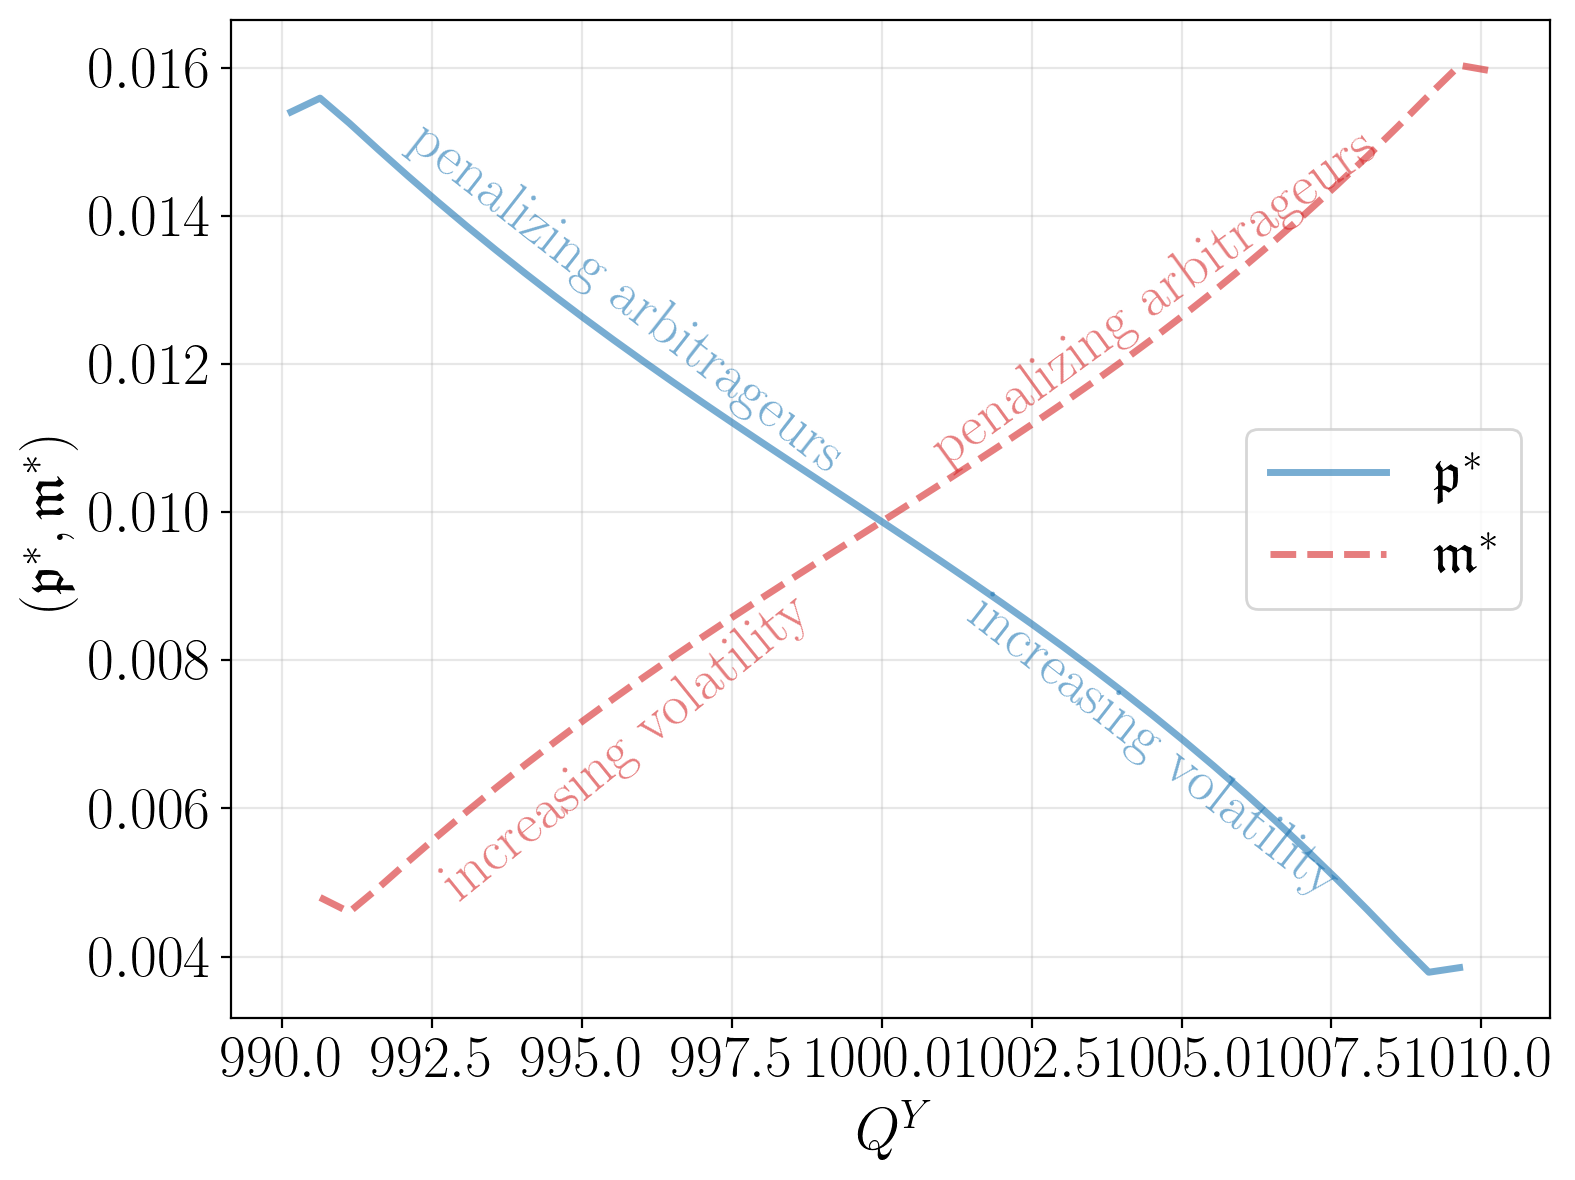

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, p[:], '-', linewidth = 2.5, label = r'$\mathfrak{p}^*$' , color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, m[:], '--', linewidth = 2.5, label = r'$\mathfrak{m}^*$', color='tab:red', alpha=0.6)

ax.text(0.3, 0.72, r"$\mathrm{penalizing}~\mathrm{arbitrageurs}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:blue',alpha=0.6, rotation = theta_deg_p)
ax.text(0.7, 0.72, r"$\mathrm{penalizing}~\mathrm{arbitrageurs}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:red',alpha=0.6, rotation = theta_deg_m)
ax.text(0.7, 0.27, r"$\mathrm{increasing}~\mathrm{volatility}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:blue',alpha=0.6, rotation = theta_deg_p)
ax.text(0.3, 0.27, r"$\mathrm{increasing}~\mathrm{volatility}$", 
        transform=ax.transAxes, fontsize=fs, ha='center', va='center', 
        color='tab:red', alpha=0.6, rotation=theta_deg_m + 3)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'$(\mathfrak{p}^*, \mathfrak{m}^*)$', fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()
plt.savefig('figures/Optimal_Fees_on_quantity.pdf', format="pdf", dpi=dpi)
plt.show()

Linear fees as a function of quantity at $t=0.5$.

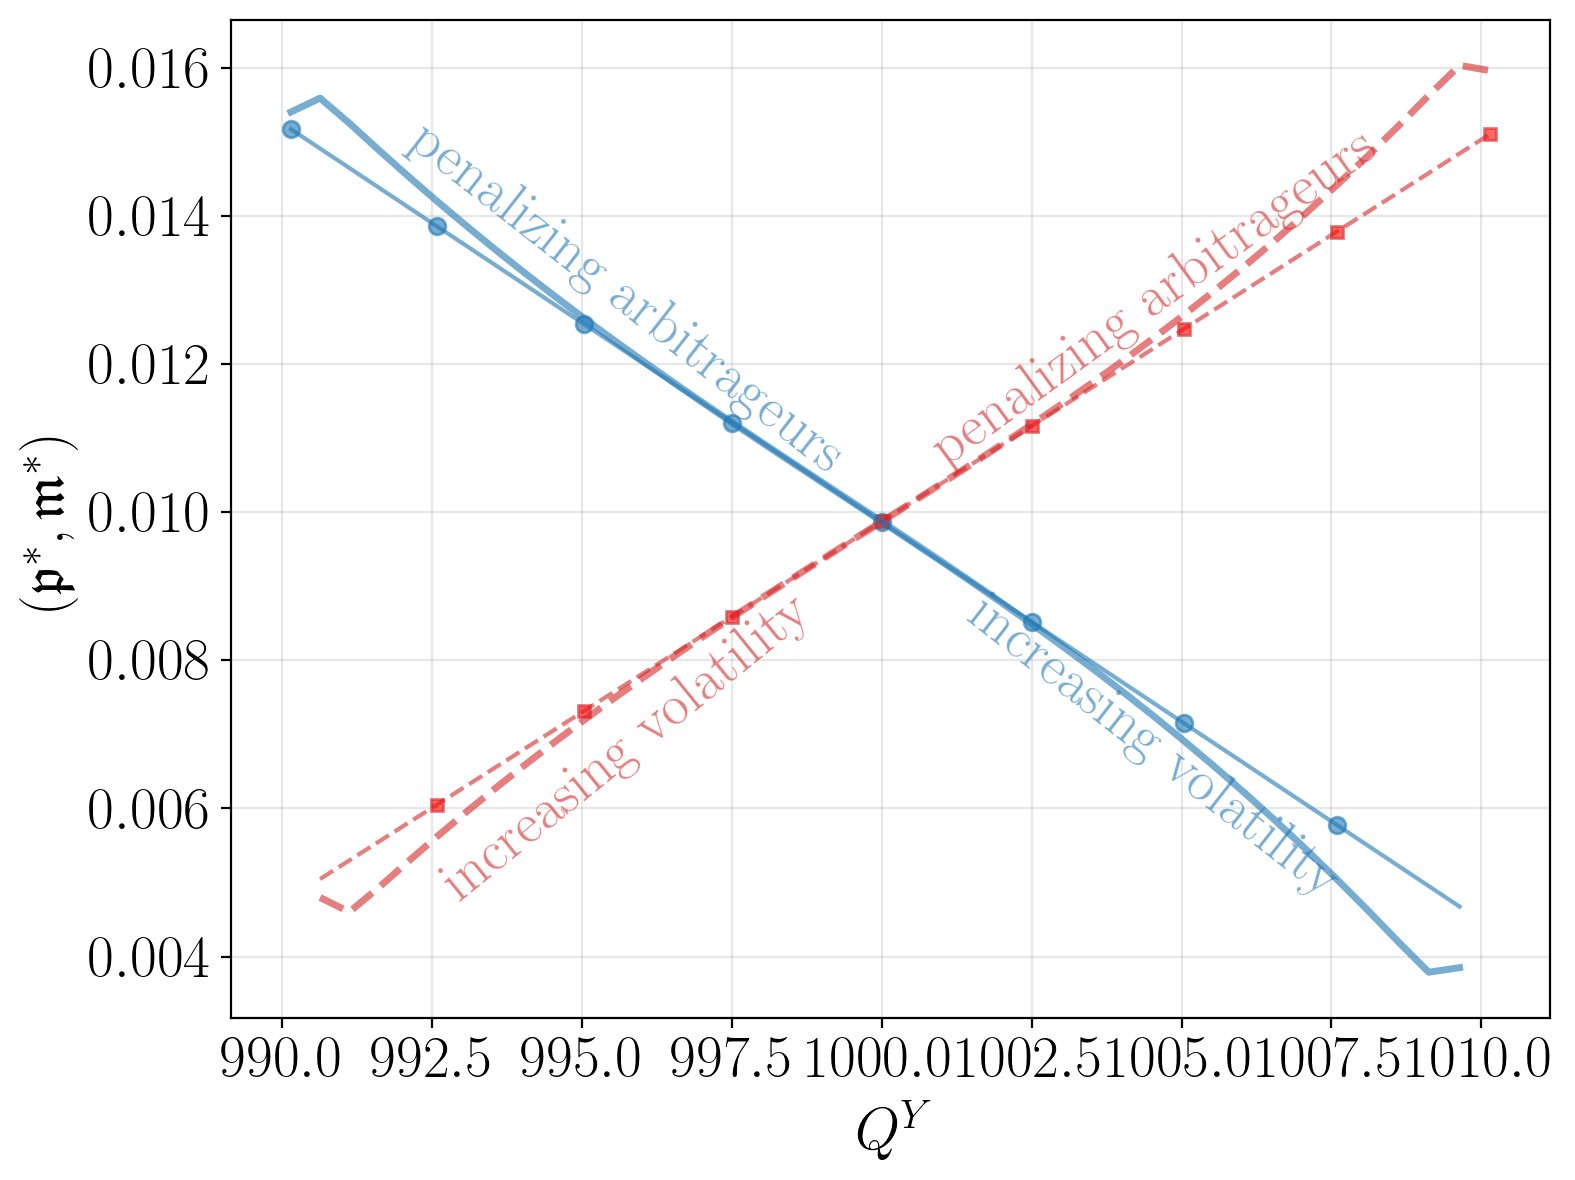

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, lin_p[:], '-o', label = r'$\mathfrak{p}^*$' , color='tab:blue', alpha=0.6, markevery=5)
ax.plot(AMM.y_grid, lin_m[:], '--s', label = r'$\mathfrak{m}^*$', color='tab:red', alpha=0.6, markersize=4, markerfacecolor='red', markevery=5)
ax.plot(AMM.y_grid, p[:], '-', linewidth = 2.5, color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, m[:], '--', linewidth = 2.5, color='tab:red', alpha=0.6)

ax.text(0.3, 0.72, r"$\mathrm{penalizing}~\mathrm{arbitrageurs}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:blue',alpha=0.6, rotation = theta_deg_p)
ax.text(0.7, 0.72, r"$\mathrm{penalizing}~\mathrm{arbitrageurs}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:red',alpha=0.6, rotation = theta_deg_m)
ax.text(0.7, 0.27, r"$\mathrm{increasing}~\mathrm{volatility}$", transform=ax.transAxes, fontsize=fs, ha='center', va='center',color='tab:blue',alpha=0.6, rotation = theta_deg_p)
ax.text(0.3, 0.27, r"$\mathrm{increasing}~\mathrm{volatility}$", 
        transform=ax.transAxes, fontsize=fs, ha='center', va='center', 
        color='tab:red', alpha=0.6, rotation=theta_deg_m + 3)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'$(\mathfrak{p}^*, \mathfrak{m}^*)$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Linear_Fees_on_quantity.pdf', format="pdf", dpi=dpi)
plt.show()

In [14]:
params["kappa"] = 0.8

In [15]:
AMM = utils.AMM(**params)
p,m = AMM._calculate_fees_t(0.5)

Optimal fees as a function of quantity at $t=0.5$ for $k=0.25$.

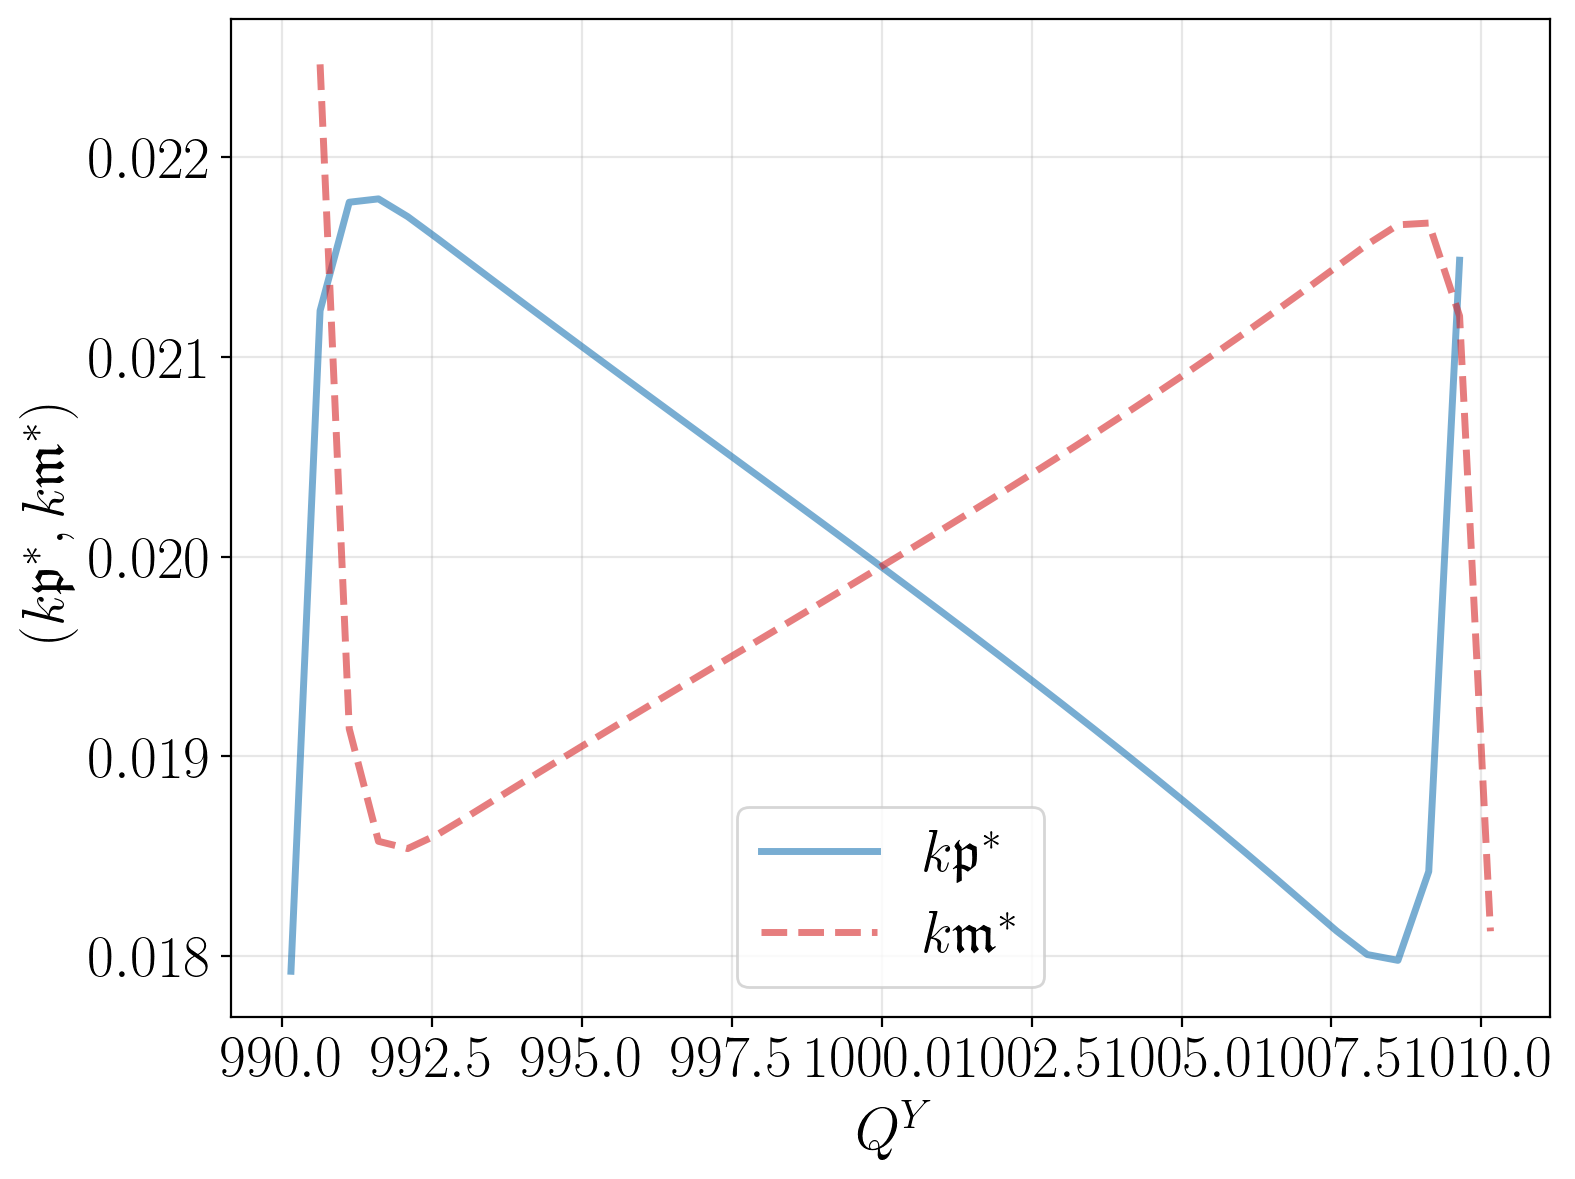

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, AMM.kappa * p[:], '-', linewidth = 2.5, label = r'$k\mathfrak{p}^*$' , color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, AMM.kappa * m[:], '--', linewidth = 2.5, label = r'$k\mathfrak{m}^*$', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'$(k\mathfrak{p}^*, k\mathfrak{m}^*)$', fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()
plt.savefig('figures/Optimal_Fees_on_quantity_k=0.25.pdf', format="pdf", dpi=dpi)
plt.show()

In [17]:
params["kappa"] = 0.1

In [18]:
AMM = utils.AMM(**params)
p,m = AMM._calculate_fees_t(0.5)

Optimal fees as a function of quantity at $t=0.5$ for $k=0.1$.

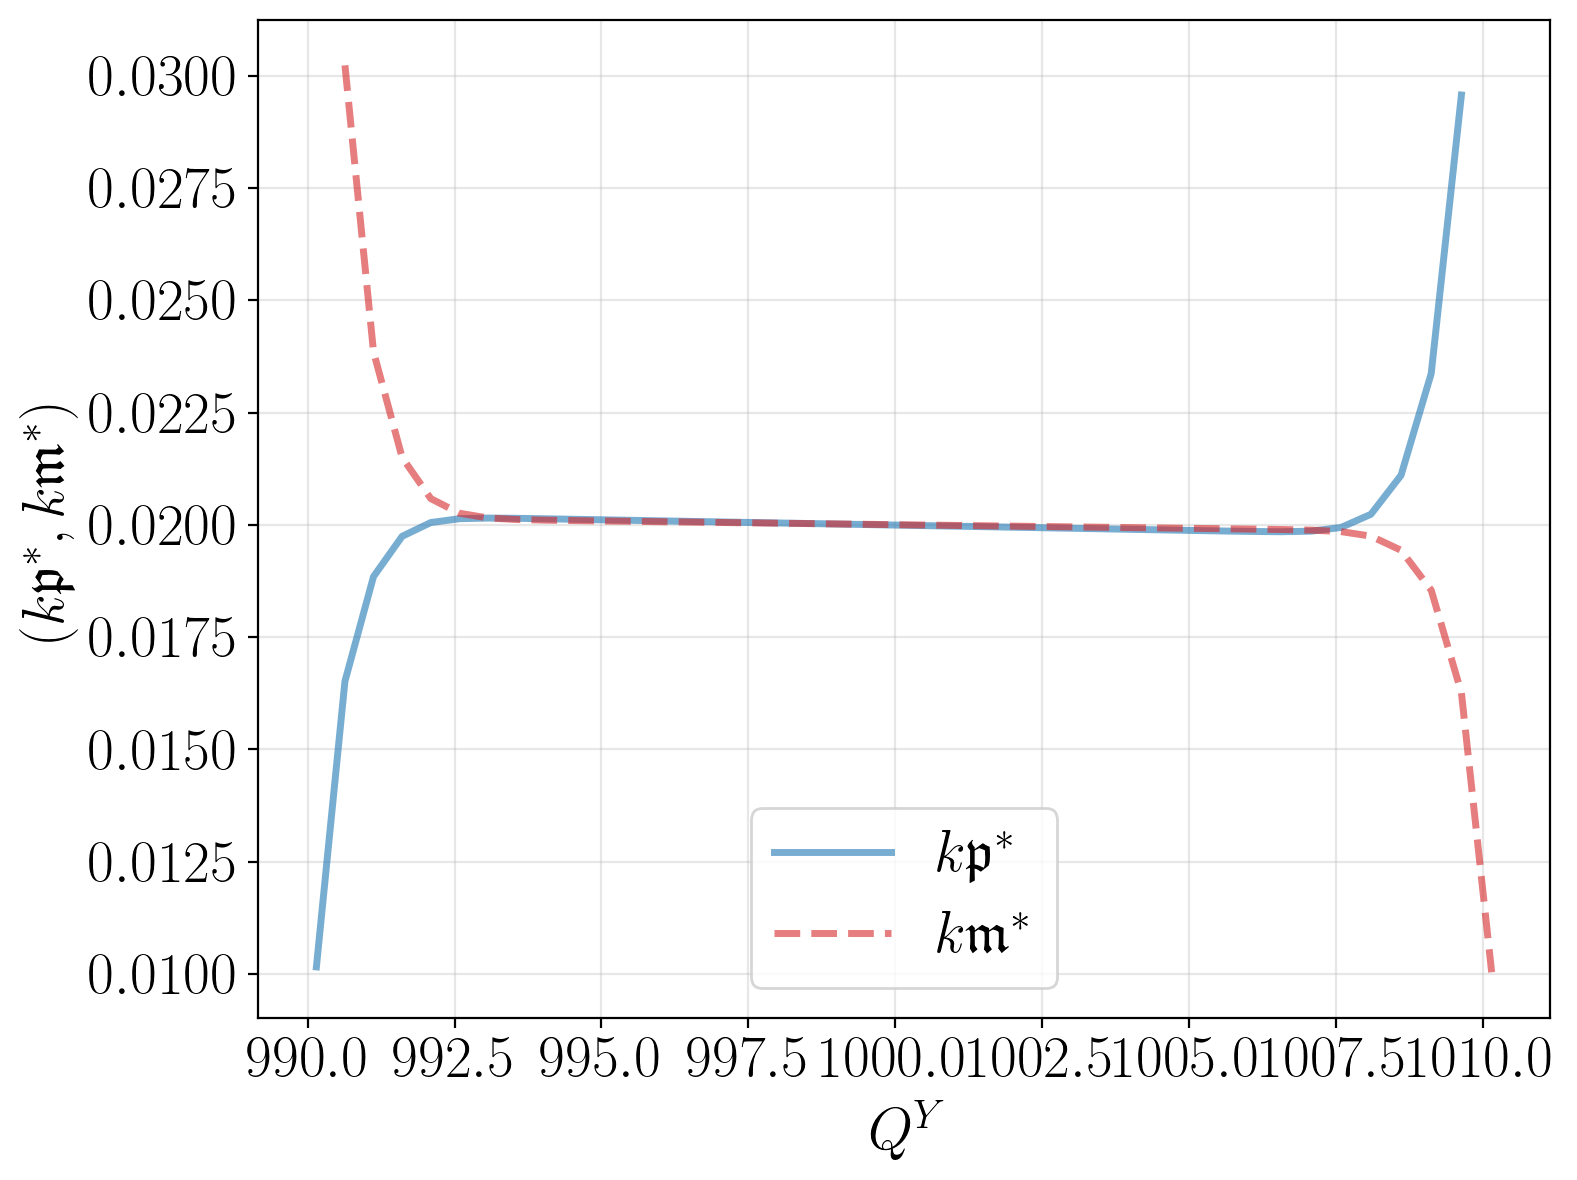

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, AMM.kappa * p[:], '-', linewidth = 2.5, label = r'$k\mathfrak{p}^*$' , color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, AMM.kappa * m[:], '--', linewidth = 2.5, label = r'$k\mathfrak{m}^*$', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'$(k\mathfrak{p}^*, k\mathfrak{m}^*)$', fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()
plt.savefig('figures/Optimal_Fees_on_quantity_k=0.1.pdf', format="pdf", dpi=dpi)
plt.show()

Behaviour of the fees at limit $k \to 0$.

In [20]:
p_0,m_0 = AMM._calculate_fees_k_0_t(0.5)

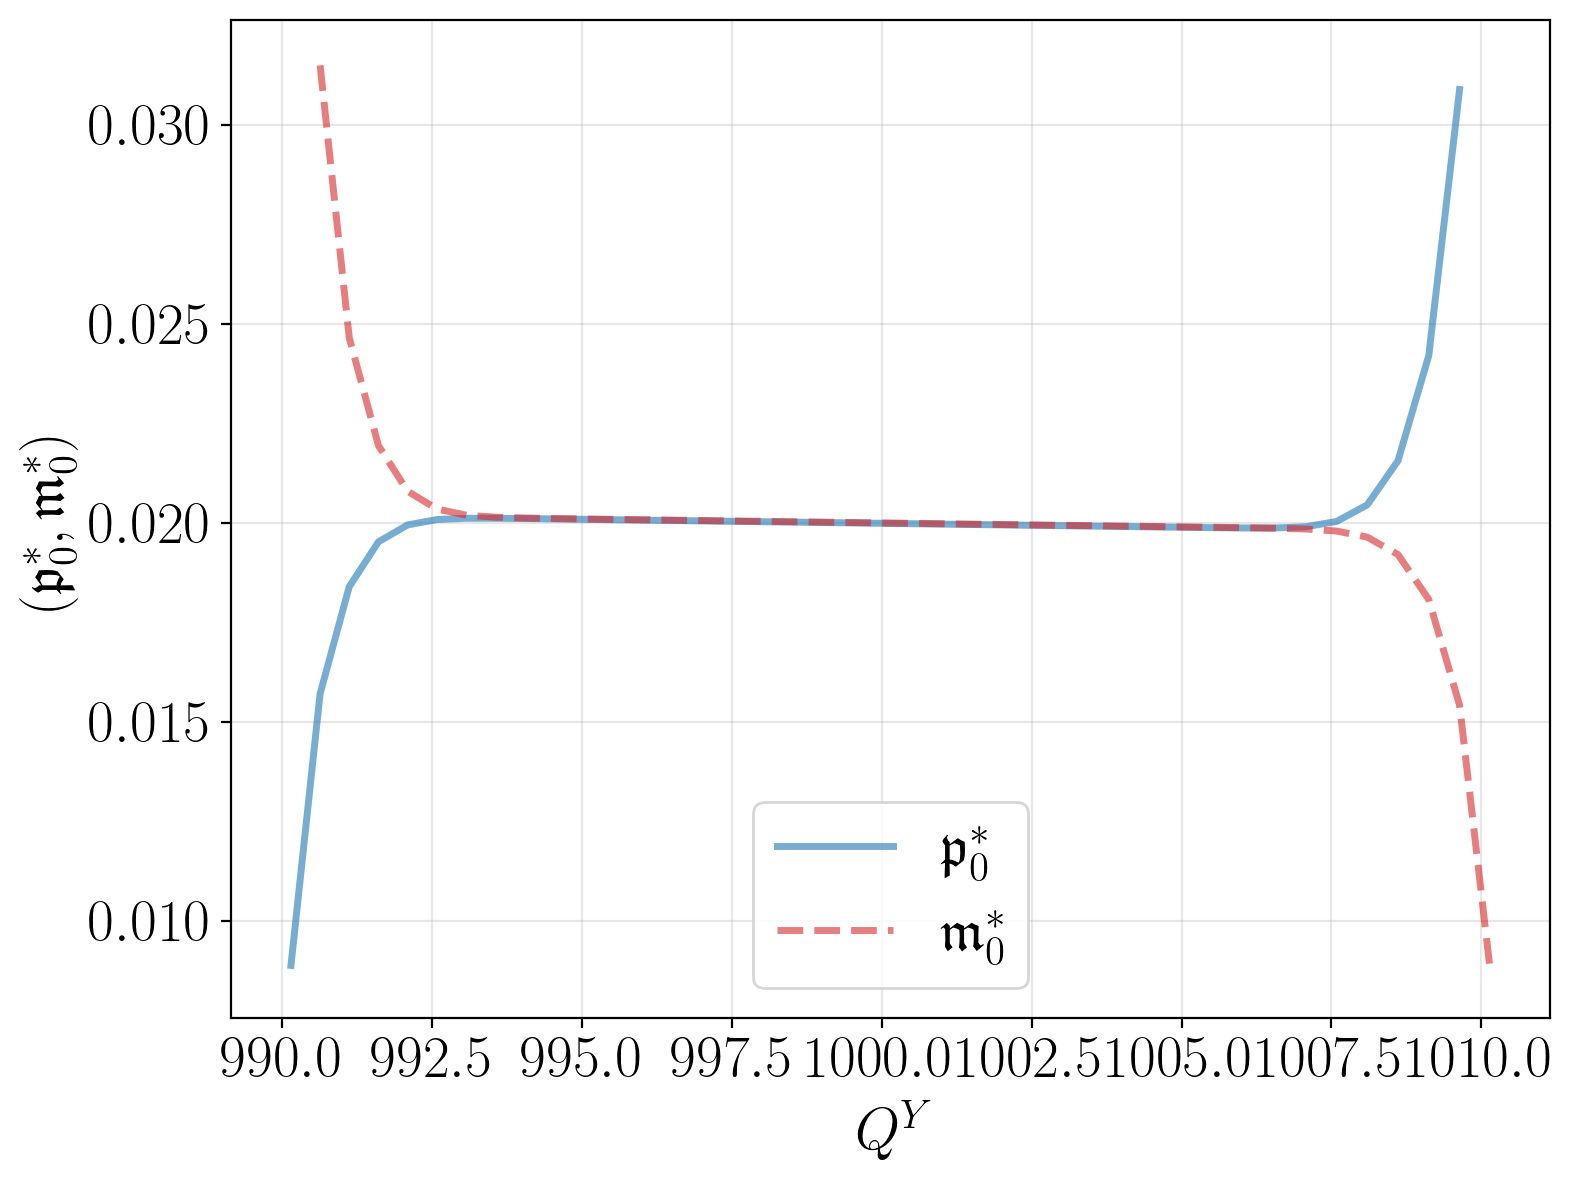

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, p_0[:], '-', linewidth = 2.5, label = r'$\mathfrak{p}^*_0$' , color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, m_0[:], '--', linewidth = 2.5, label = r'$\mathfrak{m}^*_0$', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'$(\mathfrak{p}^*_0, \mathfrak{m}^*_0)$', fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()
plt.savefig('figures/Optimal_Fees_on_quantity_k=0.pdf', format="pdf", dpi=dpi)
plt.show()

Fees depending on $\phi$ for $k=1$

In [22]:
params["kappa"] = 1

In [23]:
pen_const_value = np.array([0,50,100])

In [24]:
p = np.ones((len(AMM.y_grid), len(pen_const_value)))
m = np.ones_like(p)
for i, pen_const in enumerate(pen_const_value):
    params["pen_const"] = pen_const
    AMM = utils.AMM(**params)
    p[:,i], m[:,i] = AMM._calculate_fees_t(0.5)

In [25]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin = min(pen_const_value), vmax = max(pen_const_value))
sm = ScalarMappable(norm = norm, cmap=cmap)

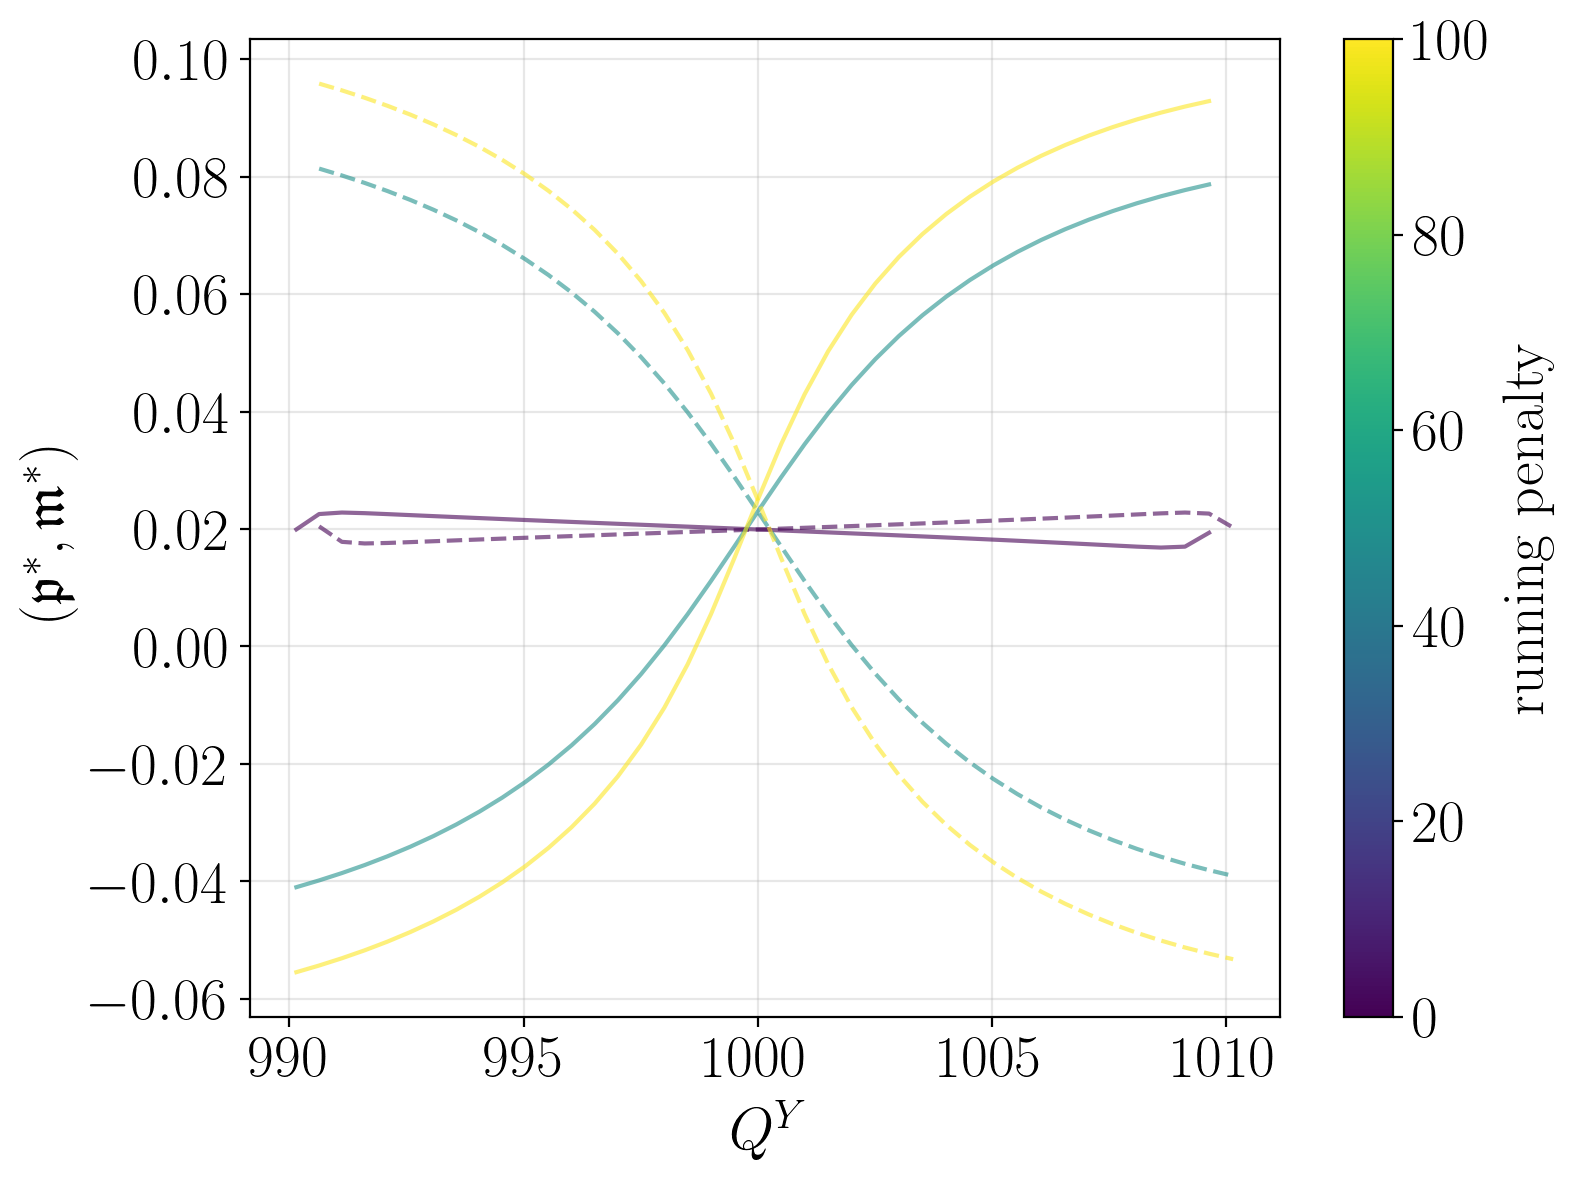

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

for i,pen in enumerate(pen_const_value):
    color = cmap(norm(pen_const_value[i]))
    ax.plot(AMM.y_grid, p[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.y_grid, m[:,i], '--', color=color, alpha=0.6)


plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\mathfrak{p}^*, \mathfrak{m}^*)$', fontsize=fs)

cbar = fig.colorbar(sm, ax = ax, orientation = "vertical")
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"$\mathrm{running}$~$\mathrm{penalty}$", fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Optimal_Fees_Nonzero_penalty_k=1.pdf', format="pdf", dpi=dpi)
plt.show()

Fees depending on $\phi$ for $k=1$

In [27]:
params["kappa"] = 0.1

In [28]:
p = np.ones((len(AMM.y_grid), len(pen_const_value)))
m = np.ones_like(p)
for i, pen_const in enumerate(pen_const_value):
    params["pen_const"] = pen_const
    AMM = utils.AMM(**params)
    p[:,i], m[:,i] = AMM._calculate_fees_t(0.5)

In [29]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin = min(pen_const_value), vmax = max(pen_const_value))
sm = ScalarMappable(norm = norm, cmap=cmap)

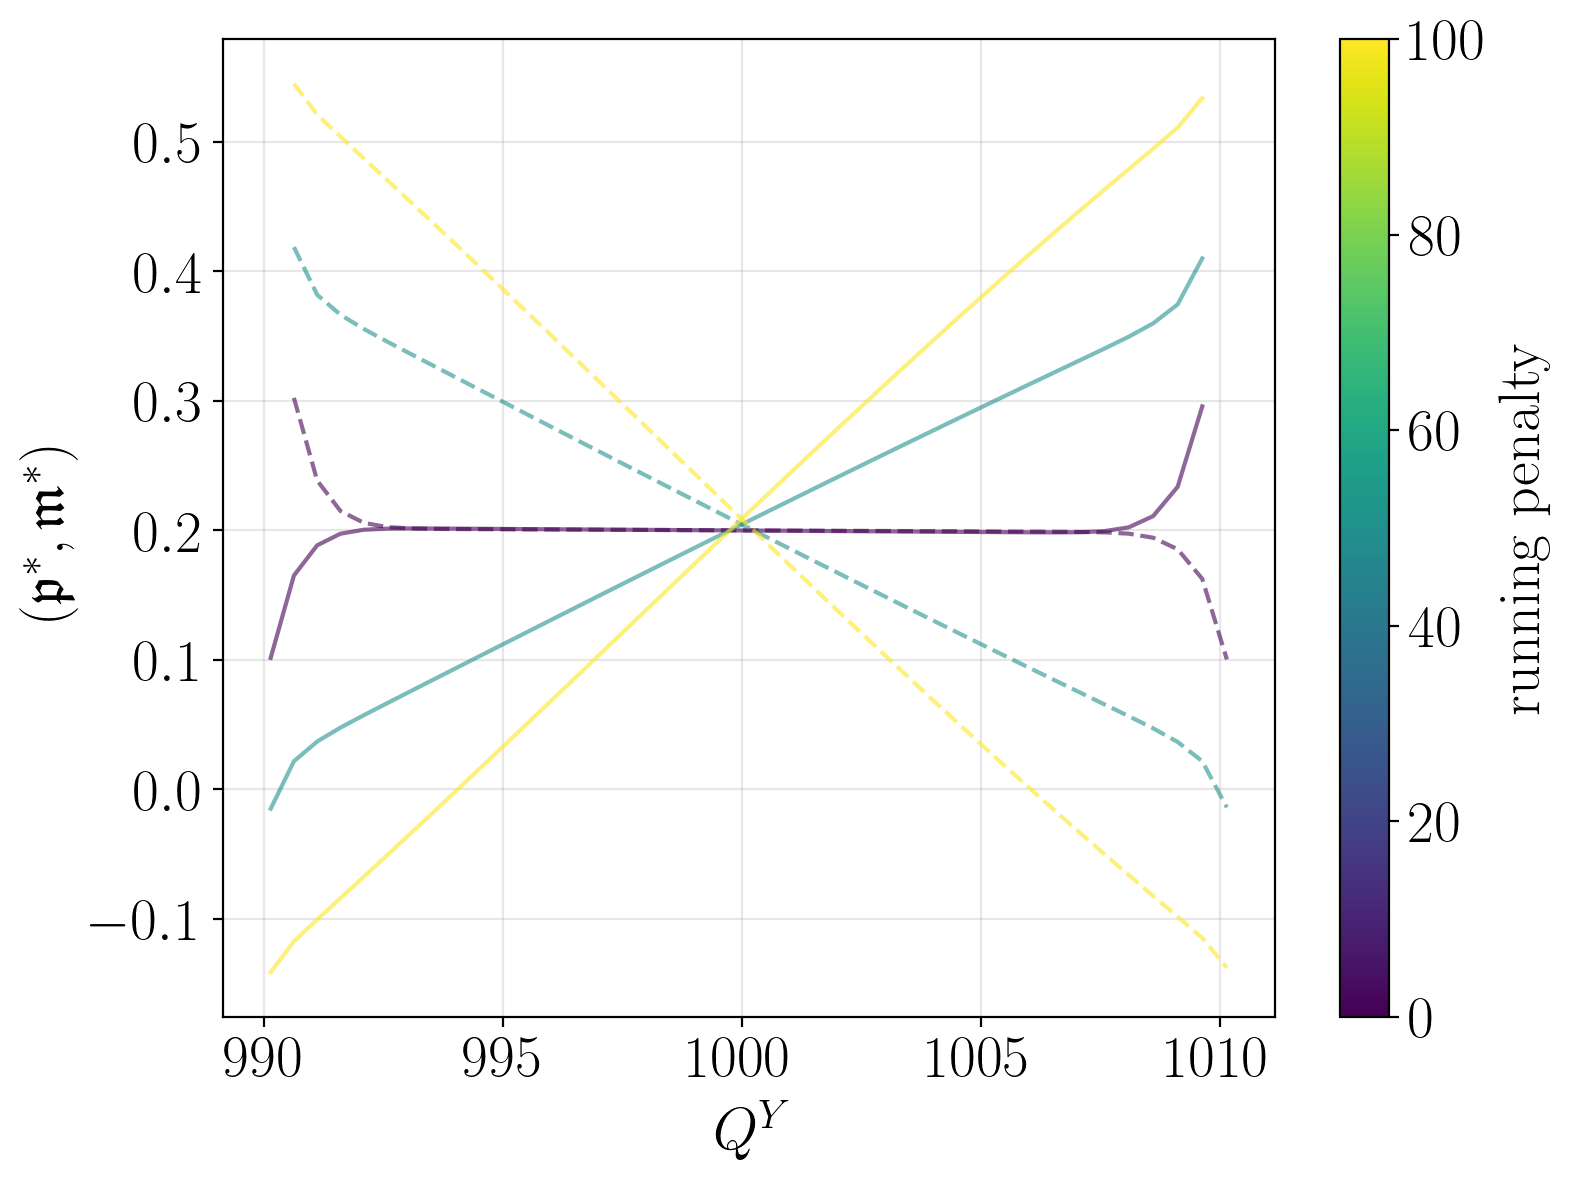

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

for i,pen in enumerate(pen_const_value):
    color = cmap(norm(pen_const_value[i]))
    ax.plot(AMM.y_grid, p[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.y_grid, m[:,i], '--', color=color, alpha=0.6)


plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\mathfrak{p}^*, \mathfrak{m}^*)$', fontsize=fs)

cbar = fig.colorbar(sm, ax = ax, orientation = "vertical")
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"$\mathrm{running}$~$\mathrm{penalty}$", fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Optimal_Fees_Nonzero_penalty_k=0.1.pdf', format="pdf", dpi=dpi)
plt.show()

In [31]:
params["kappa"] = 1
params["pen_const"] = 0
AMM = utils.AMM(**params)

In [32]:
Nt = 100
t_vector = np.linspace(0, AMM.T,num=Nt)

p = np.ones((len(AMM.y_grid), len(t_vector)))
m = np.ones_like(p)

for i,t in enumerate(t_vector):
    p[:,i],m[:,i] = AMM._calculate_fees_t(t)

In [33]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(AMM.y_grid), vmax=max(AMM.y_grid))
sm = ScalarMappable(norm=norm, cmap=cmap)

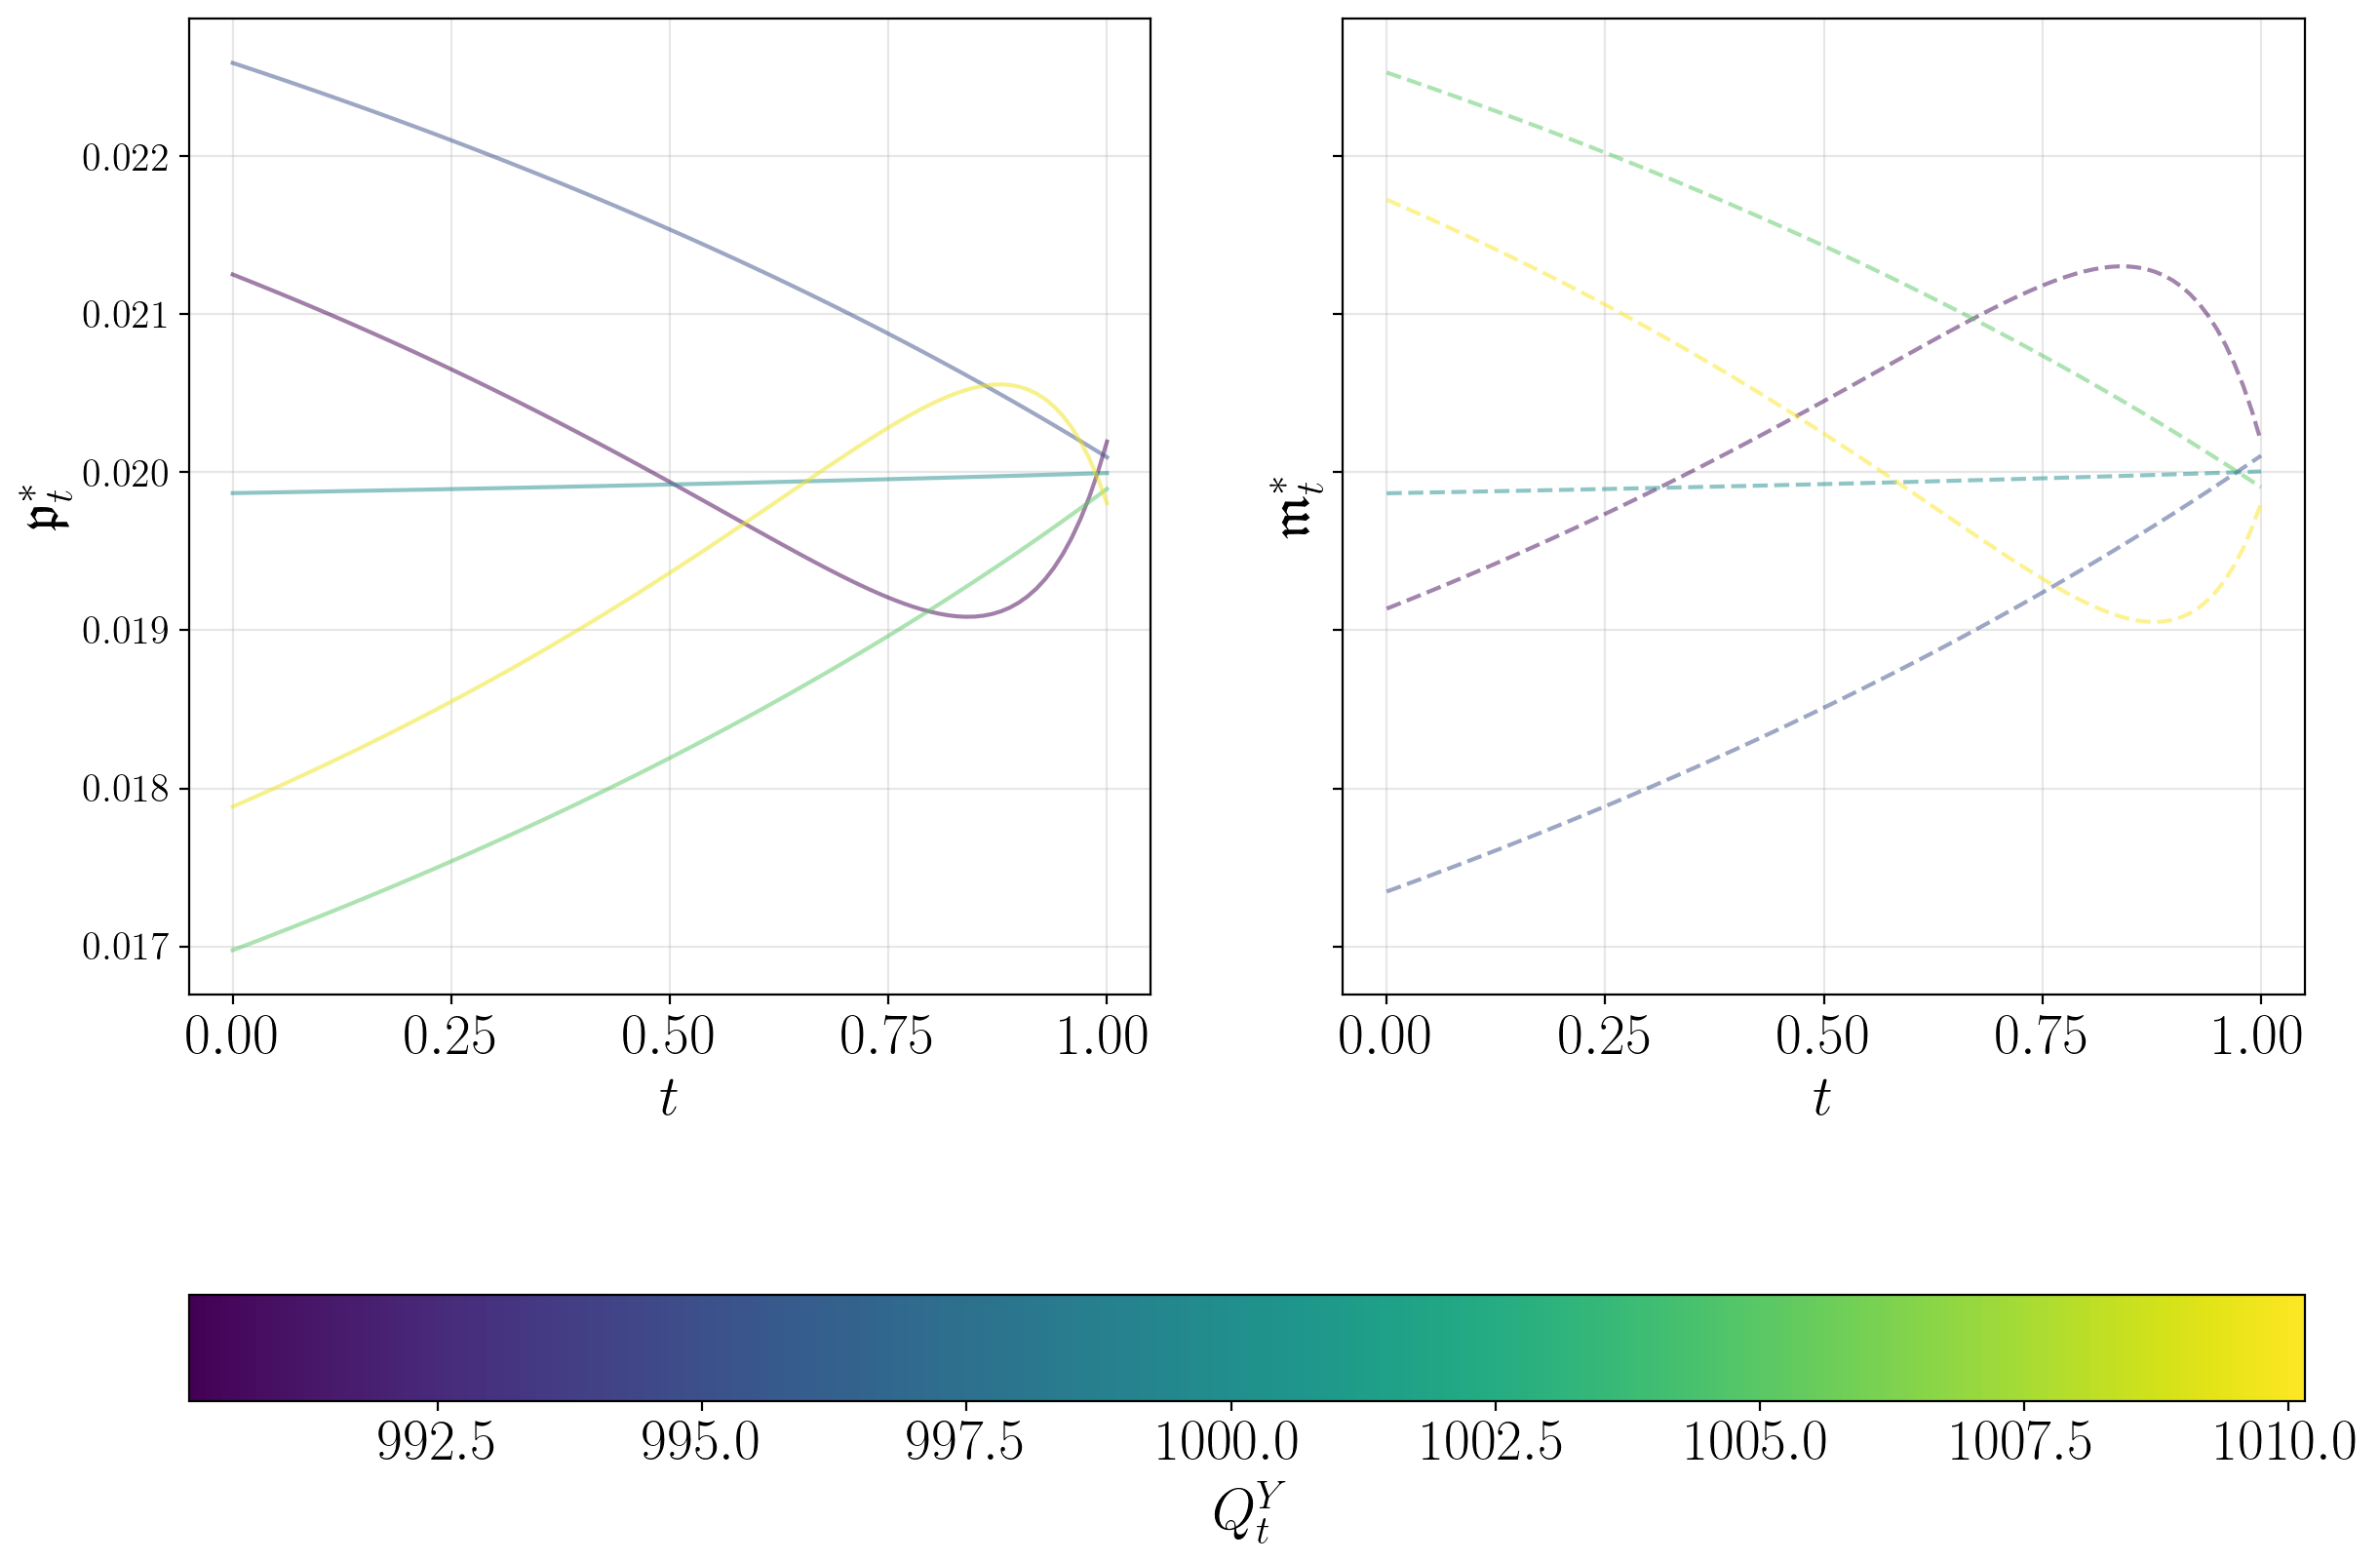

In [34]:
fig, ax = plt.subplots(1,2, figsize = (14,10), sharey=True)
value_p = [0,10,20,30,39]
value_m = [1,10,20,30,40]
for i,q in enumerate(value_p):
        color = cmap(norm(AMM.y_grid[q]))
        ax[0].plot(t_vector, AMM.kappa *p[q,:],'-', color = color, alpha = 0.5)#, label="q="+str(q), colors[iq])

    
for i,q in enumerate(value_m):
        color = cmap(norm(AMM.y_grid[q]))
        ax[1].plot(t_vector, AMM.kappa *m[q,:],'--', color = color, alpha = 0.5) #, label="q="+str(q), colors[iq])
        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\mathfrak{p}^*_t$', fontsize = fs)
ax[1].set_ylabel(r'$\mathfrak{m}^*_t$', fontsize = fs)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

ax[0].tick_params(axis='x', labelsize=fs)
ax[1].tick_params(axis='x', labelsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$Q^Y_t$', fontsize=fs)

#plt.tight_layout()
plt.savefig('figures/Optimal_fees_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()

In [35]:
params["kappa"] = 0.01
params["pen_const"] = 0
params["int_sell"] = 10
params["int_buy"] = 10
AMM = utils.AMM(**params)

In [36]:
params

{'int_sell': 10,
 'int_buy': 10,
 'kappa': 0.01,
 'oracleprice': 100.0,
 'depth': 100000000.0,
 'y_grid': array([ 990.14754298,  990.6332666 ,  991.11970575,  991.60686218,
         992.09473767,  992.58333397,  993.07265287,  993.56269616,
         994.05346561,  994.54496303,  995.03719021,  995.53014897,
         996.02384111,  996.51826846,  997.01343285,  997.50933611,
         998.00598007,  998.50336658,  999.0014975 ,  999.50037469,
        1000.        , 1000.50037531, 1001.0015025 , 1001.50338346,
        1002.00602007, 1002.50941423, 1003.01356786, 1003.51848285,
        1004.02416113, 1004.53060462, 1005.03781526, 1005.54579498,
        1006.05454573, 1006.56406946, 1007.07436814, 1007.58544372,
        1008.09729818, 1008.60993351, 1009.12335168, 1009.63755469,
        1010.15254455]),
 'y_0': 1000,
 'T': 1.0,
 'pen_const': 0}

In [37]:
Nt = 100
t_vector = np.linspace(0, AMM.T,num=Nt)

p = np.ones((len(AMM.y_grid), len(t_vector)))
m = np.ones_like(p)

for i,t in enumerate(t_vector):
    p[:,i],m[:,i] = AMM._calculate_fees_t(t)

In [38]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(AMM.y_grid), vmax=max(AMM.y_grid))
sm = ScalarMappable(norm=norm, cmap=cmap)

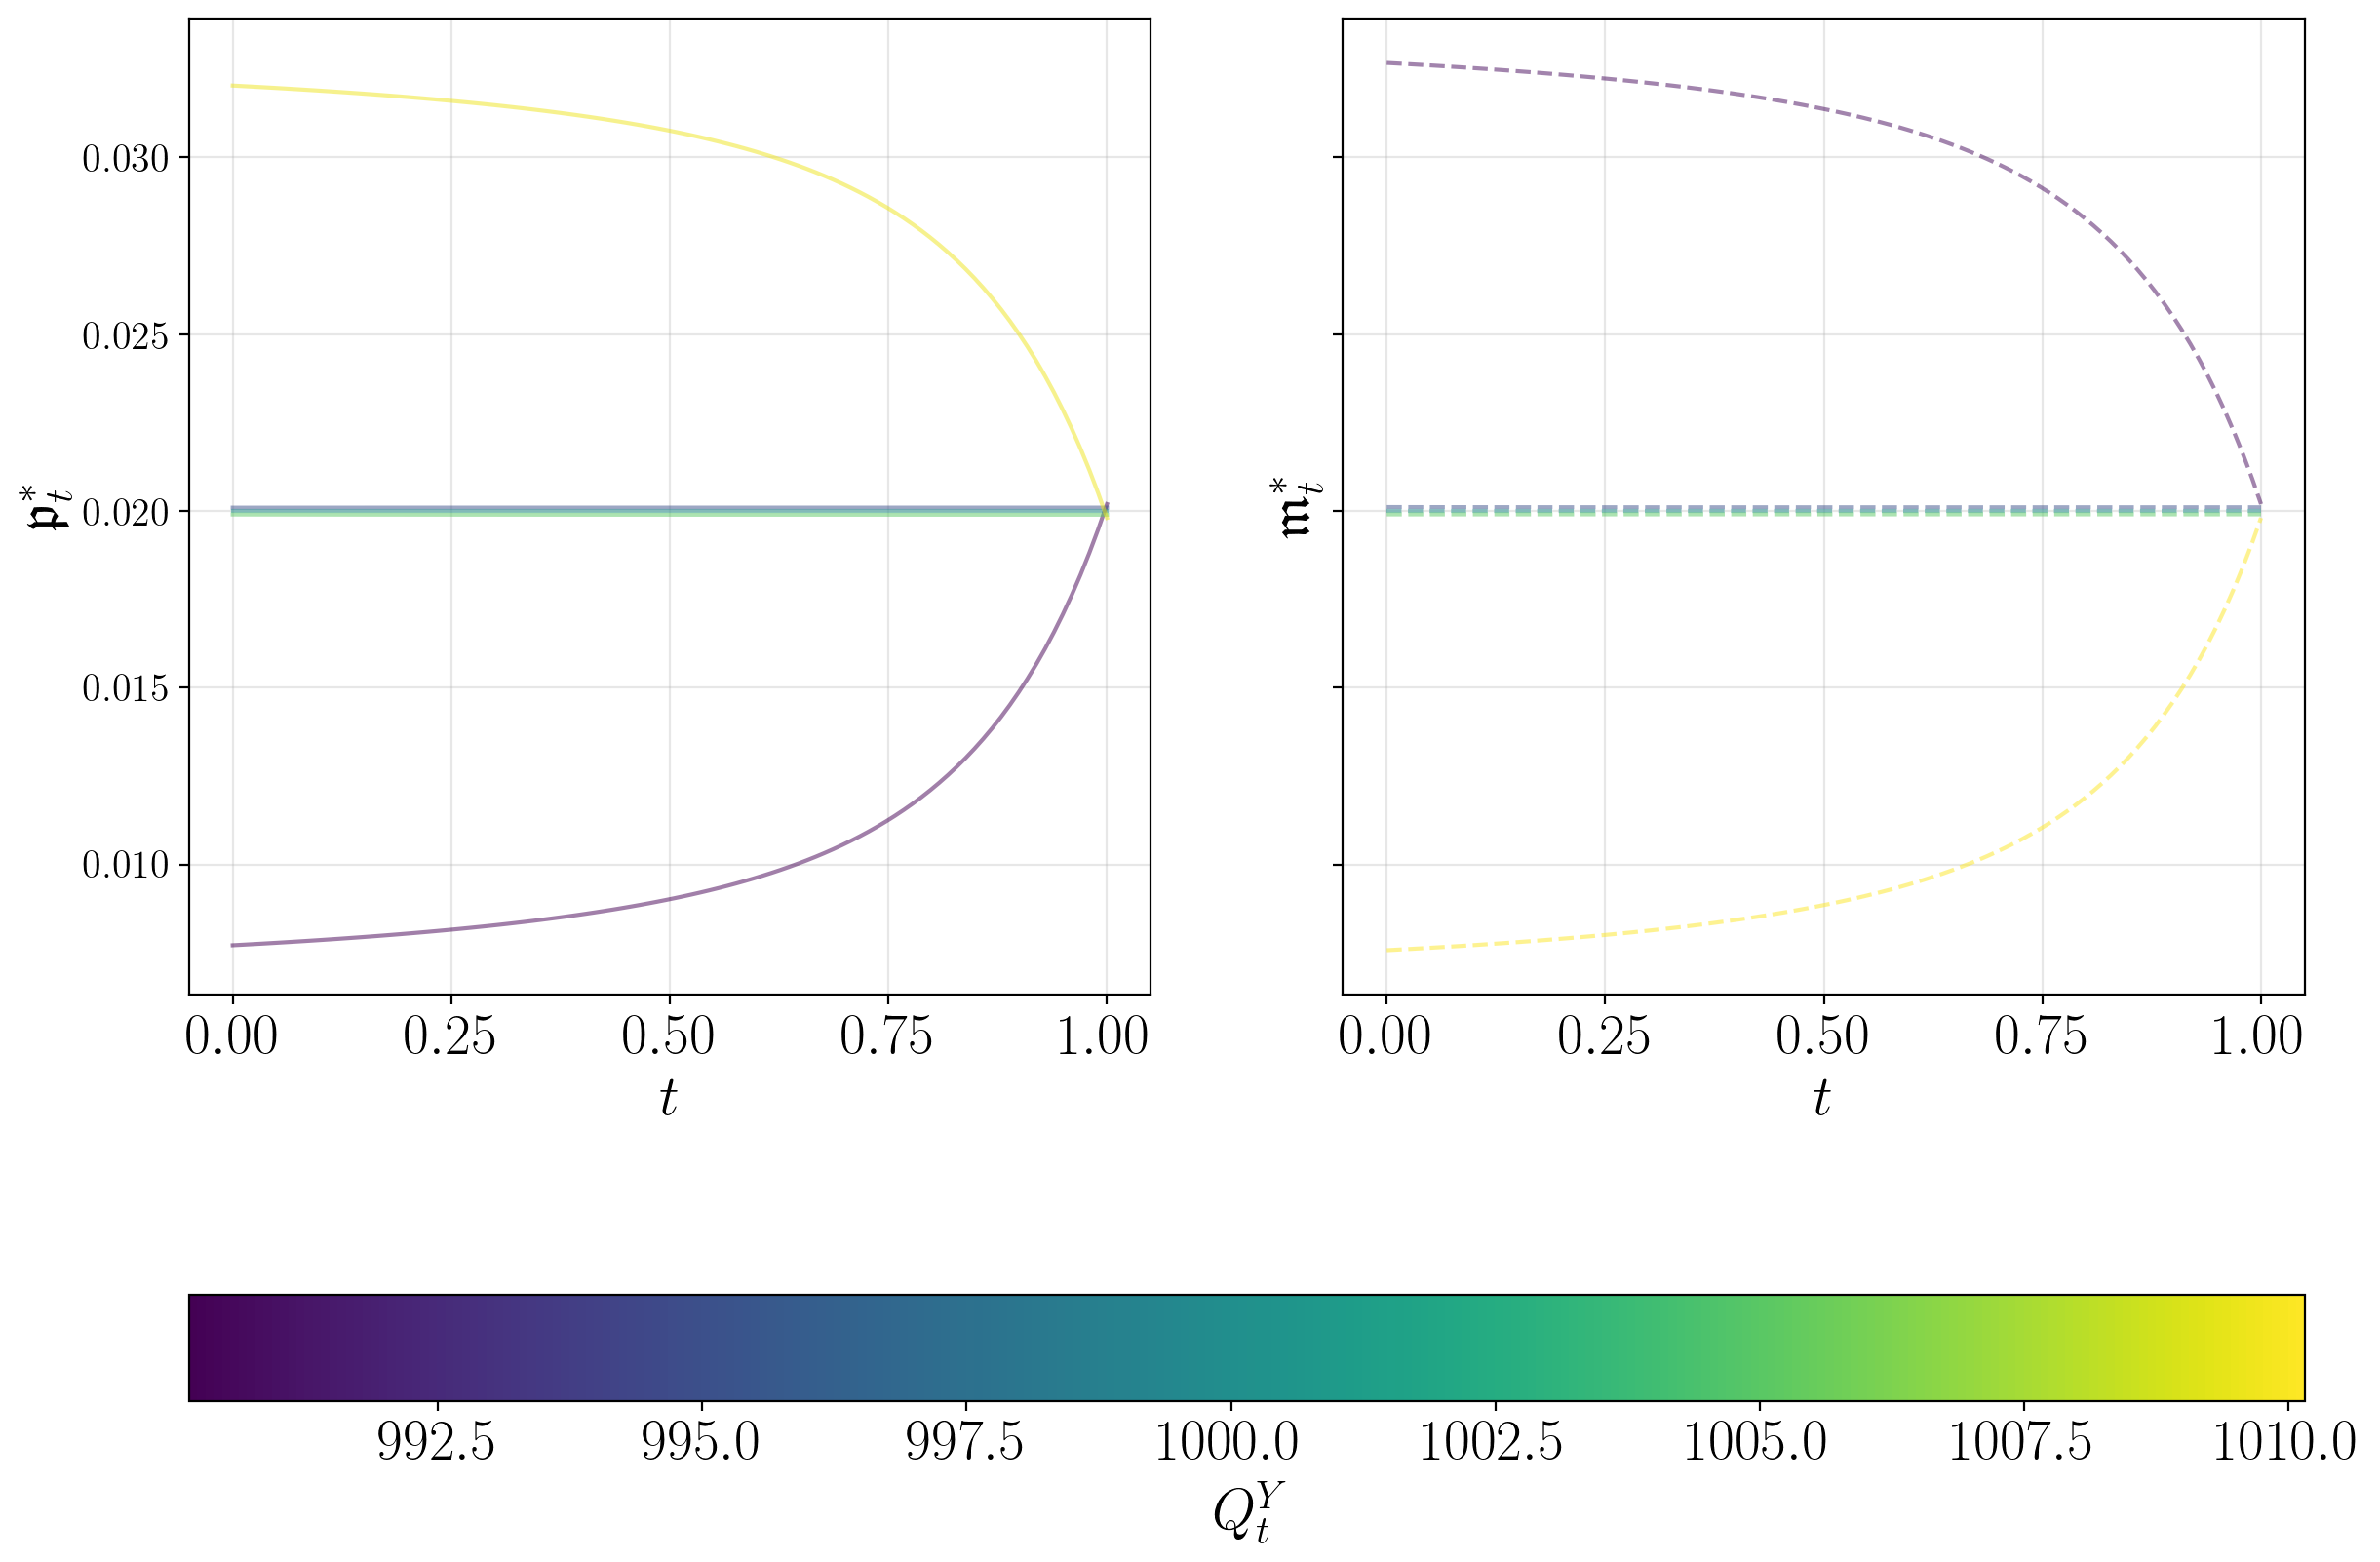

In [39]:
fig, ax = plt.subplots(1,2, figsize = (14,10), sharey=True)
value_p = [0,10,20,30,39]
value_m = [1,10,20,30,40]
for i,q in enumerate(value_p):
        color = cmap(norm(AMM.y_grid[q]))
        ax[0].plot(t_vector, AMM.kappa *p[q,:],'-', color = color, alpha = 0.5)#, label="q="+str(q), colors[iq])

    
for i,q in enumerate(value_m):
        color = cmap(norm(AMM.y_grid[q]))
        ax[1].plot(t_vector, AMM.kappa *m[q,:],'--', color = color, alpha = 0.5) #, label="q="+str(q), colors[iq])
        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\mathfrak{p}^*_t$', fontsize = fs)
ax[1].set_ylabel(r'$\mathfrak{m}^*_t$', fontsize = fs)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

ax[0].tick_params(axis='x', labelsize=fs)
ax[1].tick_params(axis='x', labelsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$Q^Y_t$', fontsize=fs)

#plt.tight_layout()
plt.savefig('figures/Optimal_fees_through_time_fct_of_Q_t.k=0.1.pdf', format="pdf", dpi=dpi)
plt.show()

In [40]:
nsims = 100000
Nt = 1000
seed = 123

Simulations of P&L

In [41]:
params["kappa"] = 0.25
params["int_sell"] = 10
params["int_buy"] = 10

In [42]:
AMM = utils.AMM(**params)

In [43]:
alpha, beta = AMM._calculate_fees_t(0.5)

In [44]:
c = np.round((alpha[20] + beta[20])/2,2)
cp = c + c*0.05
cm = c - c*0.05
c

0.08

In [45]:
(cash_Opt, _, n_sell_order_Opt, n_buy_order_Opt, traj_y_opt)= AMM.simulate_PnL(nsims = nsims, Nt =Nt, seed= seed,  strategy = "Optimal", return_trajectory=True)
(cash_Lin, _, n_sell_order_Lin, n_buy_order_Lin, traj_y_lin)= AMM.simulate_PnL(nsims = nsims, Nt =Nt, seed= seed,  strategy = "Linear", return_trajectory=True)
(cash_Const_c, _, n_sell_order_Const_c, n_buy_order_Const_c, traj_y_const_c)= AMM.simulate_PnL(nsims = nsims, Nt =Nt, seed= seed, c=c, strategy = "Constant", return_trajectory=True)
(cash_Const_p, _, n_sell_order_Const_p, n_buy_order_Const_p, traj_y_const_p)= AMM.simulate_PnL(nsims = nsims, Nt =Nt, seed= seed, c=cp, strategy = "Constant", return_trajectory=True)
(cash_Const_m, _, n_sell_order_Const_m, n_buy_order_Const_m, traj_y_const_m)= AMM.simulate_PnL(nsims = nsims, Nt =Nt, seed= seed, c=cm, strategy = "Constant", return_trajectory=True)

In [46]:
Zopt = -AMM.der_level_fct(traj_y_opt)
Zlin = -AMM.der_level_fct(traj_y_lin)
Zcons_c = -AMM.der_level_fct(traj_y_const_c)
Zcons_p = -AMM.der_level_fct(traj_y_const_p)
Zcons_m = -AMM.der_level_fct(traj_y_const_m)

QVopt = np.sum(np.diff(Zopt,axis=1)**2,axis=1)
QVlin = np.sum(np.diff(Zlin,axis=1)**2,axis=1)
QVconst_c = np.sum(np.diff(Zcons_c,axis=1)**2,axis=1)
QVconst_p = np.sum(np.diff(Zcons_p,axis=1)**2,axis=1)
QVconst_m = np.sum(np.diff(Zcons_m,axis=1)**2,axis=1)

In [47]:
Fees = ["Optimal", "Linear", "Constant_c", "Constant_p", "Constant_m"]
Revenue = [np.mean(cash_Opt),np.mean(cash_Lin),np.mean(cash_Const_c),np.mean(cash_Const_p),np.mean(cash_Const_m)]
N_sell_order = [np.mean(n_sell_order_Opt),np.mean(n_sell_order_Lin),np.mean(n_sell_order_Const_c),np.mean(n_sell_order_Const_p),np.mean(n_sell_order_Const_m)]
N_buy_order = [np.mean(n_buy_order_Opt),np.mean(n_buy_order_Lin),np.mean(n_buy_order_Const_c),np.mean(n_buy_order_Const_p),np.mean(n_buy_order_Const_m)]
Q_var = [np.mean(QVopt),np.mean(QVlin),np.mean(QVconst_c),np.mean(QVconst_p),np.mean(QVconst_m)]

In [48]:
from scipy.stats import ttest_ind

In [49]:
ttest_ind(cash_Opt,cash_Lin)

TtestResult(statistic=-0.49470141125089906, pvalue=0.6208114486231198, df=199998.0)

In [50]:
ttest_ind(cash_Opt,cash_Const_c)

TtestResult(statistic=-1.6980028914683492, pvalue=0.08950877171958155, df=199998.0)

In [51]:
df = pd.DataFrame({
    "type of fees": Fees,
    "collected fees": np.round(Revenue,2),
    "sell orders": np.round(N_sell_order,2),
    "buy orders": np.round(N_buy_order,2),
    "quadratic variation": np.round(Q_var,2),
})

In [52]:
df

,type of fees,collected fees,sell orders,buy orders,quadratic variation
0,Optimal,29.19,3.65,3.66,0.07
1,Linear,29.22,3.66,3.65,0.07
2,Constant_c,29.28,3.66,3.66,0.07
3,Constant_p,29.18,3.47,3.48,0.07
4,Constant_m,29.16,3.84,3.84,0.08


In [53]:
df.to_excel("P&L/P&Ll10k0_25.xlsx",sheet_name='P&L_lambda=10_kappa=0.25')